# Imports

In [1]:
import time
import os,pickle
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

from common import numerical_recipes as numrec
from common.baseclasses import AWA
from common.misc import autopickle

from NearFieldOptics import Materials as M

import ProbeCavityEigenfields as PCE
from ProbeCavityEigenfields import RotationalMoM as RotMOM
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
#from ProbeCavityEigenfields import RotationalMoM_new as RotMOMnew

#import numba
#eload(np) 
#reload(numba) 
#print('Numba version:',numba.__version__)
print('Numpy version:',np.__version__) # version 0.6 appears not compatible with numpy 1.22 - 1.24

<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Bi2Se3_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "PMMA_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "sio2_300nm_extracted_epsilon_cone_A=2a.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_230K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_30K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Erik_BSTS_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_295K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_360K.csv"...
<material_types.Ta

# Build probe

In [2]:
a_nm=20
a=a_nm*1e-7 #in cm
L=24e-4 #probe length in cm, assuming cantilever thickness 4e-4 #Arrow probe: https://www.nanoworld.com/tapping-mode-reflex-coated-afm-tip-arrow-ncr
L_microns=L*1e4
taper_angle=21 # Arrow probe: https://www.researchgate.net/figure/SEM-image-of-an-AFM-tip-attached-to-cantilever_fig6_224406883
geometry='hyperboloid'
PCE.Probe.dtype = np.complex64

WL_THz=300e-4 #300 microns wavelength
freq_THz=1/WL_THz
freq=30*freq_THz # 30 THz

Nsubnodes=2
Nnodes=244

probe_name = '%s_a=%inm_taper=%i_L=%imicrons_Nnodes=%i'%(geometry.capitalize(),a_nm,taper_angle,L_microns,Nnodes)
#probe_name = 'MidIRHyperboloid_FreqDepNormalization_L=%imicrons'%(L*1e4,)
print('Building probe %s...'%probe_name)

Building probe Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244...


Attemping to load from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244)_Probe.pickle"...
<__init__._ProbesCollection.__setitem__>:
	Registering probe "Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244"...
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244)_Probe.pickle"!


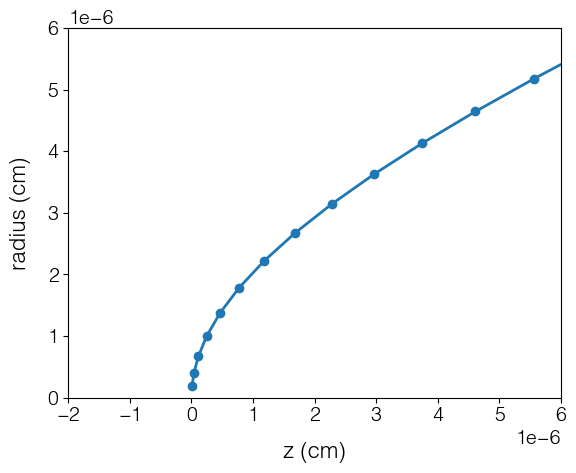

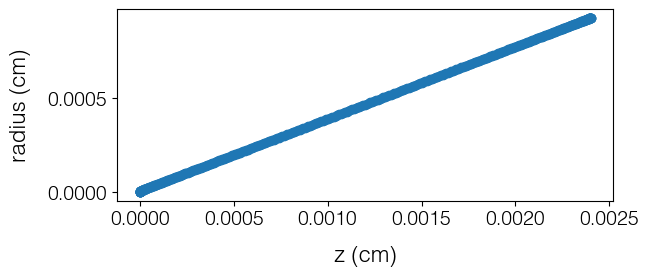

In [3]:
# Load the probe or build the probe
recompute = False
overwrite = True
try:
    if recompute: raise ValueError
    P = PCE.load(probe_name,PCE.Probe)
except (FileNotFoundError,ValueError): 

    P=PCE.Probe(Nnodes=Nnodes,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.TS,\
                     a=a,taper_angle=taper_angle,geometry=geometry,
                freq=freq,gap=a,name=probe_name)

    RotMOM.quadlimit = int(1e4)
    #Zmirror = P.get_mirror_impedance(k=0,kappa_min=.1/L,recompute=False,sommerfeld=True,Nkappas=244*8)
    Zmirror = P.get_mirror_impedance(sommerfeld=False)
    #Zself = P.get_self_impedance(k=P.get_k(),recompute=True)
    rhos,Js = P.solve_eigenmodes(condition_ZM=True,condition_ZS=False,ZMthresh=0,recompute_impedance=False)
    
    try: PCE.save(P,overwrite=overwrite)
    except OSError: pass
    
ztip=P.get_gap()
zs=P.get_zs()
Rs=P.get_radii()
k=P.get_k()
    
plt.figure()
Rs.plot(marker='o')
plt.gca().set_aspect('equal')
plt.xlim(-a,3*a)
plt.ylim(0,3*a)
plt.ylabel('radius (cm)')
plt.xlabel('z (cm)')

plt.figure()
Rs.plot(marker='o')
plt.gca().set_aspect('equal')
plt.ylabel('radius (cm)')
plt.xlabel('z (cm)')

RotMOM.quadlimit = int(1e4)
#Zmirror = P.get_mirror_impedance(k=P.get_k(),nonsingular=False,recompute=True)
#Zmirror = P.get_mirror_impedance(k=0,nonsingular=False,recompute=True)
#Zmirror = P.get_mirror_impedance(k=P.get_k(),farfield=False,recompute=True,sommerfeld=True,Nkappas=244*8,rp=rp_au,\
#                                kappa_min=P.get_k()*.01)

(0.0, 15.0)

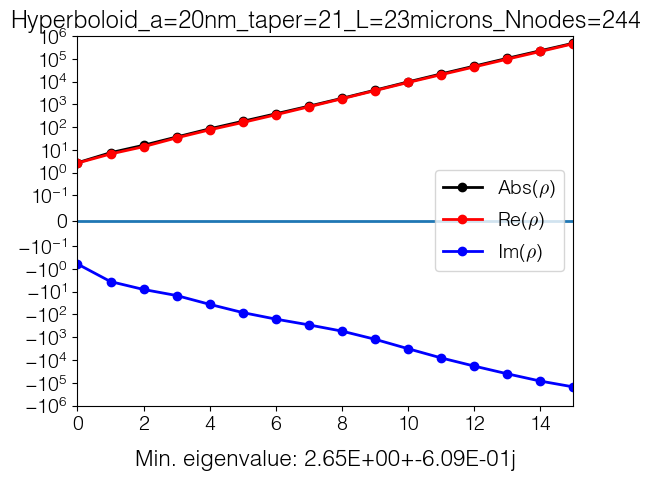

In [4]:
P.plot_eigenrhos()
plt.xlim(0,15)

# Probe Gap Spectroscopy

In [5]:
gaps = np.logspace(-1.5, 1.5, 100) * P.get_a() # in cgs units, like everything else here
#gaps = np.linspace(.1,10,100)*a
reload(PS)

recompute=False
overwrite=True
#kwargs=dict(sommerfeld=True, kappa_max = None, Nkappas = 244*4 ) # adaptive kappa_max
kwargs=dict(sommerfeld=False,basis_gap = P.get_a()) # basis is important

try:
    if recompute: raise ValueError
    ProbeGapSpectroscopy = PCE.load(P, PS.ProbeGapSpectroscopyParallel, overwrite_probe=True)
    
except (FileNotFoundError,ValueError):
    ProbeGapSpectroscopy = PS.ProbeGapSpectroscopyParallel(Probe=P, gaps=gaps,
                                                        ncpus=8, backend='loky',
                                                        Nmodes=50, reversed=False,**kwargs)
    try: PCE.save(ProbeGapSpectroscopy,overwrite=overwrite)
    except OSError: pass

Attemping to load from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244)_ProbeGapSpectroscopy.pickle"...
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244)_ProbeGapSpectroscopy.pickle"!


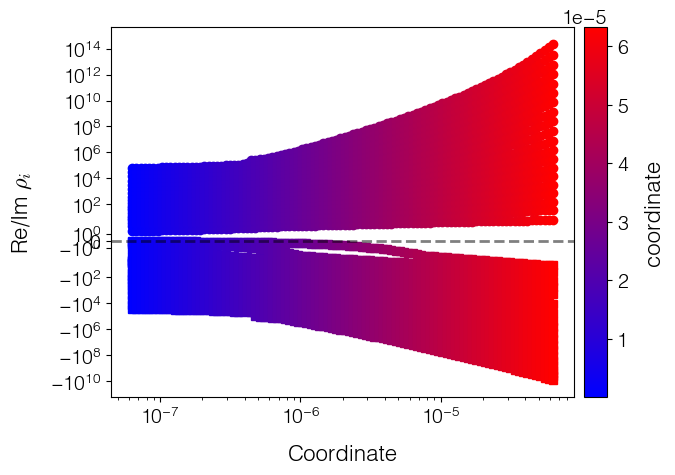

In [6]:
ProbeGapSpectroscopy.plot_eigenrhos_scatter(Nmodes=20,versus_coord=True)
plt.gcf().axes[0].set_xscale('log')

Text(0.5, 0, 'Gap size')

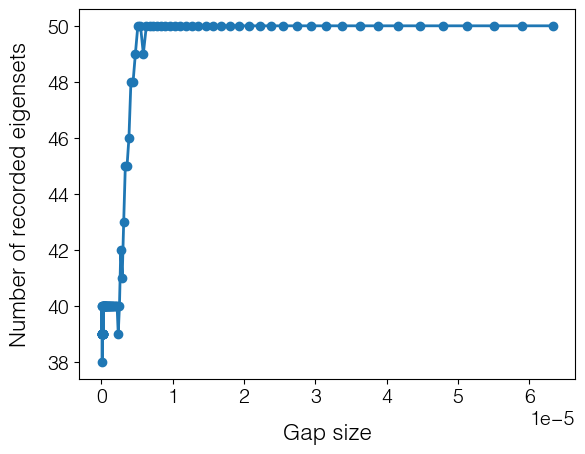

In [7]:
gaps = ProbeGapSpectroscopy._recorded_eigenrhos.keys()
Ns = [len(ProbeGapSpectroscopy._recorded_eigenrhos[gap]) for gap in gaps]
plt.plot(gaps,Ns,marker='o')
plt.ylabel('Number of recorded eigensets')
plt.xlabel('Gap size')

## Classify and plot dispersion of eignmodes with gap

In [8]:
Nmodes=50
# Start from the highest reliable coordinate to make sure we don't miss the lowest order modes
ProbeGapSpectroscopy(Nmodes=Nmodes,reversed=True,by_rho=True,debug=False,coordmax=None)
eigenrhos = ProbeGapSpectroscopy.get_eigenrhos_AWA(Nmodes=Nmodes)
eigencharges = ProbeGapSpectroscopy.get_eigencharges_AWA()

Classifying eigensets by eigenindex, with reversal...
Looking for Nmodes=38 (maximum uniformly available in coordinate range).
	Progress: 99.00%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.align_eigencharge_signs>:
	Aligning signage of 38 eigenmode charges over 100 coordinates...


Text(0.5, 0, 'Gap/a')

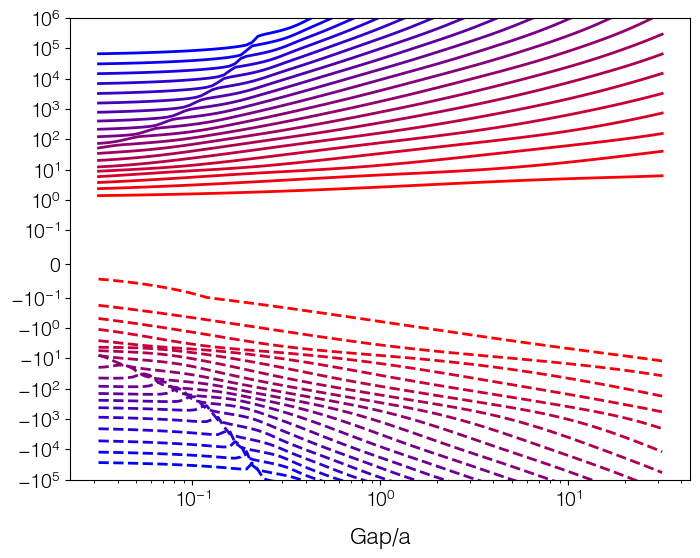

In [9]:
Nmodes_plot=20
colors=zip(np.linspace(1,0,Nmodes_plot),[0]*Nmodes_plot,np.linspace(0,1,Nmodes_plot))
plt.figure(figsize=(8,6))

a=P.get_a()
gaps=eigenrhos.axes[1]
for n in range(Nmodes_plot):
    c=next(colors)
    rhos=eigenrhos[n]
    plt.plot(gaps/a,rhos.real,marker='',color=c)
    plt.plot(gaps/a,rhos.imag,marker='',color=c,ls='--')
    
plt.gca().set_yscale('symlog',linthresh=.1)
plt.ylim(-1e5,1e6)
#plt.xlim(.0074,.0076)
#plt.xlim(np.min(freqs),.002)
plt.gca().set_xscale('log')
plt.xlabel('Gap/a')

## Compute brightness associated to eigenmodes

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenbrightness_AWA>:
	Computing brightnesses across 100 spectroscopy coordinates...


Text(0.5, 1.0, 'Brightness')

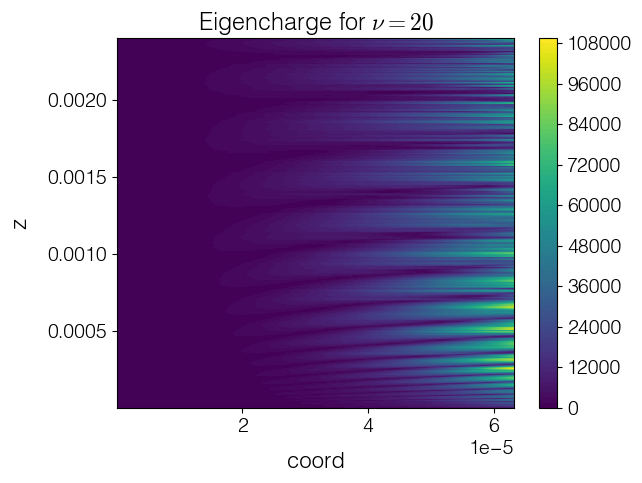

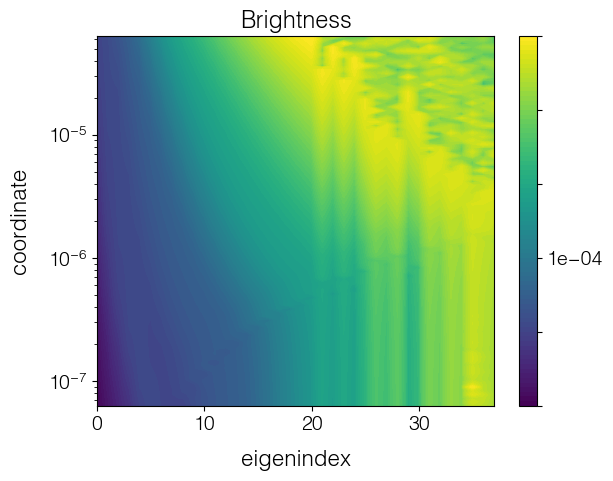

In [10]:
eigenind=20
np.abs(ProbeGapSpectroscopy._eigencharges_AWA[eigenind].real).plot(plotter=plt.contourf)
plt.title(r'Eigencharge for $\nu=%i$'%eigenind)

angles=np.linspace(10,90,20)
all_vs = ProbeGapSpectroscopy.get_eigenbrightness_AWA(recompute=False,
                                                        angles=angles,
                                                        verbose=True)
plt.figure()
np.abs(all_vs).plot(plotter=plt.contourf,log_scale=True)
plt.gca().set_yscale('log')
plt.title('Brightness')

## Save after having computed properties of eigencharges

In [11]:
overwrite=True
save=True

if save:
    try: PCE.save(ProbeGapSpectroscopy,overwrite=overwrite)
    except OSError: pass # didn't want to overwrite

Successfully saved to file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244)_ProbeGapSpectroscopy.pickle"!


# Build Encoded Eigenfields from gap spectroscopy

In [26]:
gaps = np.logspace(-1.5, 1.5, 100) * P.get_a() # in cgs units, like everything else here
#gaps = np.linspace(.1,10,100)*a
reload(PS)

recompute=True
overwrite=True

try:
    if recompute: raise ValueError
    EE = PCE.load(P, PS.EncodedEigenfields, overwrite_probe=True)
    
except (FileNotFoundError,ValueError):
    gap0 = P.get_a()/10
    Nmodes=15
    EE = PS.EncodedEigenfields(ProbeGapSpectroscopy,gap0=gap0, Nmodes=Nmodes,
                                kappa_min=None, kappa_max=20/a,
                                Nkappas=244*8, qquadrature=PCE.numrec.GL)
    try: PCE.save(EE,overwrite=overwrite)
    except OSError: pass

<ProbeCavityEigenfields.ProbeSpectroscopy.EncodedEigenfields.__init__>:
	Encoding 15 eigenfields to gap=2e-07 across 100 gap values from gap=(6.3e-08 to 6.3e-05)...
<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.93E-07...
	Updating eigencharges...
	Updating self impedance...
	Updating mirror impedance...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
Successfully saved to file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid_a=20nm_taper=21_L=23microns_Nnodes=244)_EncodedEigenfields.pickle"!


## Build library for quick calculation of 2D material contrast

In [ ]:
recompute=True
save=True
overwrite=True

if not hasattr(EE,'Rmat2D_interp_subs_r') or recompute:
    q0 = 1/EE.get_probe().get_a() # A typical scale for qp
    qps = np.logspace(-3, 2, 100) * q0
    EE.build_Rmat2D_library(qps,
                            interp_kwargs = dict(s=0,kx=1,ky=1)) # smoothing factor `s=0` is for interpolation, `kx` and `ky` are degrees of spline

    if save:
        try: PCE.save(EE,overwrite=overwrite)
        except OSError: pass # didn't want to overwrite

<ProbeCavityEigenfields.ProbeSpectroscopy.EncodedEigenfields.build_Rmat2D_library>:
	Computing library of 2D material reflectance matrices from 15 eigenfields to 100 x 100 qp values...


# Probe Frequency Spectroscopy

## Load or build spectroscopy

In [ ]:
freqs=np.linspace(0.5,80,200)*freq_THz
reload(PS)

recompute=False

try:
    if recompute: raise ValueError
    ProbeFreqSpectroscopy = PCE.load(P, PS.ProbeFrequencySpectroscopyParallel, overwrite_probe=True)
    
except (FileNotFoundError,ValueError):
    ProbeFreqSpectroscopy = PS.ProbeFrequencySpectroscopyParallel(Probe=P, freqs=freqs,
                                                                 ncpus=8, backend='loky',
                                                                 Nmodes=20, reversed=False)
    PCE.save(ProbeFreqSpectroscopy,overwrite=True)

In [ ]:
ProbeFreqSpectroscopy.plot_eigenrhos_scatter(Nmodes=10,versus_coord=True)
plt.gcf().axes[0].set_xscale('linear')

## Classify and plot dispersion of probe poles

In [ ]:
ProbeFreqSpectroscopy(Nmodes=20,reverse=False,by_rho=True,debug=False)
eigenrhos = ProbeFreqSpectroscopy.get_eigenrhos_AWA(Nmodes=20)
eigencharges = ProbeFreqSpectroscopy.get_eigencharges_AWA(Nmodes=20)

In [ ]:
np.abs(eigencharges[0]).plot() # higher order eigencharges show some weird sharp defects (eigenvalue error?), but oh well

In [ ]:
N=14
colors=zip(np.linspace(1,0,N),[0]*N,np.linspace(0,1,N))
plt.figure(figsize=(8,6))

freqs=eigenrhos.axes[1]
for n in range(N):
    c=next(colors)

    if n==0:
        label1=r'Re($\rho$)'
        label2=r'Im($\rho$)'
    else: label1=label2=None
        
    rhos=eigenrhos[n]
    plt.plot(freqs/freq_THz,rhos.real,marker='',color=c,label=label1)
    plt.plot(freqs/freq_THz,rhos.imag,marker='',color=c,label=label2)
    
plt.gca().set_yscale('symlog',linthresh=.1)
plt.ylim(-1e7,1e8)
#plt.xlim(.0074,.0076)
#plt.xlim(np.min(freqs),.002)
plt.xlabel('Frequency (THz)')
plt.ylabel(r'$\rho$',fontsize=20)
plt.legend(frameon=True)

#--- Plot some antenna mode frequencies

f=.8
plt.axvline(f/(2*L)/freq_THz,color='k',ls='--') #This is where probe ~ lambda/2 antenna - radiative Q?
plt.axvline(f/L/freq_THz,color='k',ls='--') #This is where probe ~ lambda antenna - radiative Q?
plt.axvline(f*3/(2*L)/freq_THz,color='k',ls='--')
plt.axvline(f*2/(L)/freq_THz,color='k',ls='--')

plt.axhline(0,ls=':',color='k',alpha=.4)
plt.title(ProbeFreqSpectroscopy.get_probe().get_name())